<a href="https://colab.research.google.com/github/lszam/brazilianplatform/blob/main/BatimetriaResidual_Wessel2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estudos da Plataforma Continental Brasileira - Colaboração Projeto LEPLAC**
# Batimetria Residual - Método ORS
O objetivo deste código é realizar a separação regional-residual em um grid batimétrico usando o método **Optimal Robust Separator (ORS)**.

***Nesta versão, a entrada é feita por upload de um grid tipo Surfer da batimetria.***

Referências:

ORS - Wessel, P. (2016). Regional–residual separation of bathymetry and revised estimates of Hawaii plume flux. Geophysical Journal International, 204(2), 932-947. doi: 10.1093/gji/ggv472

Escala de cores científica - Thyng, K. M., Greene, C. A., Hetland, R. D., Zimmerle, H. M., & DiMarco, S. F. (2016). True colors of oceanography. Oceanography, 29(3), 10.

*Luizemara Szameitat 26/02/2025 - luizemara@gmail.com, luizemara@usp.br*



## **Teoria**

A filtragem ORS (Optimal Robust Separator) é uma combinação de 2 filtros. Primeiro, é aplicado um filtro de mediana, que irá remover ruídos (alta frequência) e picos espúrios. Em seguida, é aplicado um filtro Gaussiano, que irá definir a superfície regional. O próximo passo é realizar a separação regional-residual, sendo a saída então o residual da batimetria.

A largura do filtro de mediana deve corresponder à menor escala das feições geológicas que se deseja manter no residual (comprimento de onda mínimo). Aqui, foi observado o resultado ao longo de um perfil para escolher um valor que minimizasse os picos no assoalho oceânico.

No caso do parâmetro de gaussiana, deve-se escolher uma medida que corresponda à largura média das estruturas geológicas consideradas como regionais.

## **Parâmetros de entrada**



In [19]:
filename = "BR-DTM-REV2024.grd"  # Nome do arquivo Grid Surfer v7
median_width = 140  # Largura do filtro de mediana (*1000 m)
gaussian_width = 300  # Largura do filtro gaussiano

# **1. Ambiente**

In [20]:
!apt-get install -y gdal-bin
!pip install gdal
!pip install crm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.ndimage import median_filter, gaussian_filter
from osgeo import gdal


# Função para carregar Grid Surfer
def load_surfer_grid(filename):
    dataset = gdal.Open(filename)
    if dataset is None:
        raise ValueError("Falha ao abrir o arquivo. Verifique o formato e o caminho do arquivo.")
    band = dataset.GetRasterBand(1)
    bathymetry = band.ReadAsArray()
    nodata_value = band.GetNoDataValue()

    # Obtendo informações georreferenciadas
    transform = dataset.GetGeoTransform()
    print(transform)

    # Criando máscara para valores válidos
    mask = np.ones_like(bathymetry, dtype=bool)
    if nodata_value is not None:
        mask = bathymetry != nodata_value

    return bathymetry, mask, transform


# Função filtro ORS para valores válidos
def apply_ors_filter(bathymetry, mask, median_width=10, gaussian_width=10):
    '''
    Função filtro ORS (Wessel, 2016, doi 10.1093/gji/ggv472) para valores válidos

    Parâmetros:
    -----------
    median_width: int
      define quantos pixels vizinhos serão considerados.
    gaussian_width:
      define a suavização (valores maiores, superfície mais lisa)
    '''
    filtered = np.copy(bathymetry)
    filtered[~mask] = np.nan  # definir NaNs para ignorar no filtro

    # Filtro de Mediana: substitui os valores centrais por uma mediana dos vizinhos
    median_filtered = median_filter(np.nan_to_num(filtered, nan=np.nanmean(filtered)), size=median_width)

    gaussian_filtered = gaussian_filter(median_filtered, sigma=gaussian_width)

    # Restaurar valores NaN
    gaussian_filtered[~mask] = np.nan
    return median_filtered, gaussian_filtered

# Função para separação Regional-Residual
def regional_residual_separation(bathymetry, regional, mask):
    residual = bathymetry - regional
    residual[residual < 0] = 0  # truncar valores negativos
    residual[~mask] = np.nan  # máscara para valores NoData
    return residual

# **2. Filtragem**

In [ ]:
# Input
bathymetry, mask, transform = load_surfer_grid(filename)

# Filtro ORS
median_filtered, regional = apply_ors_filter(bathymetry, mask, median_width, gaussian_width)
residual = regional_residual_separation(bathymetry, regional, mask)

# Plot dos resultados
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(bathymetry, cmap='terrain', origin='lower')
axs[0].set_title("Batimetria Original")
axs[0].invert_yaxis()
axs[1].imshow(regional, cmap='terrain', origin='lower')
axs[1].set_title("Superfície Regional")
axs[1].invert_yaxis()
axs[2].imshow(residual, cmap='terrain', origin='lower')
axs[2].set_title("Topo Residual")
axs[2].invert_yaxis()
plt.tight_layout()
plt.show()


(-5941304.29982836, 1000.0, 0.0, 1224047.3785410495, 0.0, -1000.0)


In [ ]:
# Perfil
chosen_lon = -3750000     # meridiano para o perfil

# Função para extrair perfil ao longo de um meridiano escolhido
def extract_meridian_profile(bathymetry, transform, lon):
    x_origin, pixel_width, _, y_origin, _, pixel_height = transform
    col_idx = int((lon - x_origin) / pixel_width)  # Converte a longitude para índice de coluna
    return bathymetry[:, col_idx], np.arange(bathymetry.shape[0]) * pixel_height + y_origin

original_profile, latitudes = extract_meridian_profile(bathymetry, transform, chosen_lon)
median_profile, _ = extract_meridian_profile(median_filtered, transform, chosen_lon)
regional_profile, _ = extract_meridian_profile(regional, transform, chosen_lon)
residual_profile, _ = extract_meridian_profile(residual, transform, chosen_lon)

# Plot do perfil
plt.figure(figsize=(14, 5))
plt.plot(latitudes, original_profile, label="Original", linestyle='-', linewidth=1.5)
plt.plot(latitudes, median_profile, label="Mediana", linestyle='--', linewidth=1.5)
plt.plot(latitudes, regional_profile, label="Regional", linestyle='-.', linewidth=1.5)
plt.plot(latitudes, residual_profile, label="Residual", linestyle=':', linewidth=1.5)
plt.xlabel("Y")
plt.ylabel("Profundidade (m)")
plt.legend()
plt.title(f"Perfil Batimétrico em X={chosen_lon}")
plt.grid()
plt.show()

## **3. Mapas**

In [15]:
!pip install cmocean -q

# cmocean colormaps (Thyng et al., 2016) http://tos.org/oceanography/assets/docs/29-3_thyng.pdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 8.6 MB/s eta 0:00:00


AttributeError: module 'cmocean' has no attribute 'deep'

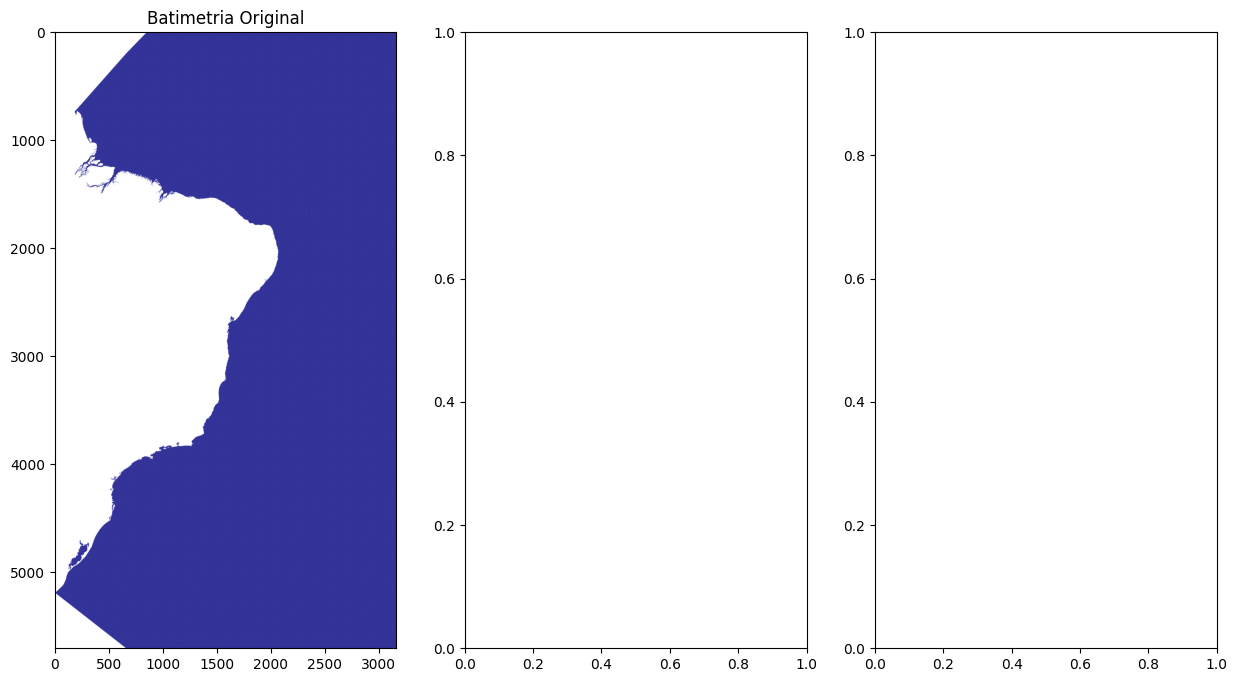

In [13]:
import cmocean

# Plot dos resultados
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(bathymetry, cmap='terrain', origin='lower')
axs[0].set_title("Batimetria Original")
axs[0].invert_yaxis()
axs[1].imshow(regional, cmap=cmocean.cm.deep, origin='lower')
axs[1].set_title("Superfície Regional")
axs[1].invert_yaxis()
axs[2].imshow(residual, cmap='terrain', origin='lower')
axs[2].set_title("Topo Residual")
axs[2].invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:

#limite_lateral = "https://www.marinha.mil.br/dhn/sites/www.marinha.mil.br.dhn/files/LimiteLateralMaritimo.zip"
#linha_de_base = "https://idem.dhn.mar.mil.br/geoserver/ows?service=wms&version=1.1.1&request=GetCapabilities"


## **4. Arquivos de saída**

Arquivos tipo grid Surfer:

In [ ]:
from osgeo import gdal, osr
import numpy as np

def save_surfer_grid(input_filename, output_filename, data):
    """Salva um array como um grid Surfer"""
    # Abrir o arquivo original para obter metadados
    dataset = gdal.Open(input_filename)
    if dataset is None:
        raise ValueError("Erro ao abrir o arquivo de entrada.")

    driver = gdal.GetDriverByName("GSBG")  # GSBG é o formato binário do Surfer Grid v7
    out_dataset = driver.Create(output_filename, dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Float32)

    if out_dataset is None:
        raise ValueError("Erro ao criar o arquivo de saída.")

    # Copiar transformações georreferenciadas
    out_dataset.SetGeoTransform(dataset.GetGeoTransform())
    # Copiar sistema de coordenadas
    out_dataset.SetProjection(dataset.GetProjection())
    # Escrever os dados no novo arquivo
    out_band = out_dataset.GetRasterBand(1)
    out_band.WriteArray(data)
    # Definir valor NoData
    out_band.SetNoDataValue(np.nan)

    # Salvar e fechar
    out_band.FlushCache()
    del out_dataset
    print(f"Grid de saída salvo como {output_filename}")


# Nomes dos arquivos
regional_filename = filename.replace('.grd', '_ORSregional.grd')
residual_filename = filename.replace('.grd', '_ORSresidual.grd')

# Salvar os grids regional e residual, com base no grid de entrada
save_surfer_grid(filename, regional_filename, regional)
save_surfer_grid(filename, residual_filename, residual)

from google.colab import files

files.download(regional_filename)
files.download(str(regional_filename+".aux.xml"))
files.download(residual_filename)
files.download(str(residual_filename+".aux.xml"))


Grid de saída salvo como BR-DTM-REV2024_regional.grd
Grid de saída salvo como BR-DTM-REV2024_residual.grd


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>